In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
with open('train_motorcycles.pickle', 'rb') as to_read:
    total_df = pickle.load(to_read)
to_read.close()

In [3]:
total_df.dropna(inplace=True)

In [4]:
total_df = total_df[total_df['make'] != 'harley']

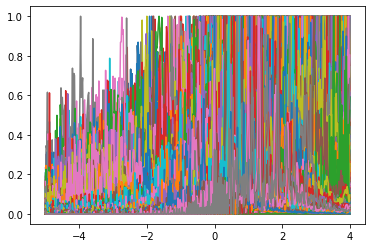

In [7]:
plotter=total_df.drop('make',axis=1)
for i in plotter.index:
    plt.plot(plotter.loc[i,:])

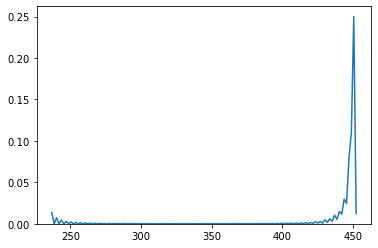

In [8]:
sns.kdeplot((total_df <= total_df.quantile(.99)).sum(axis=1))

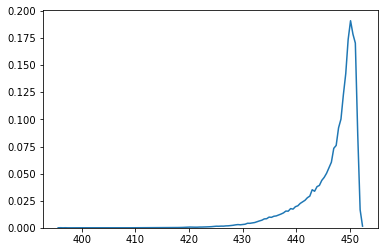

In [9]:
total_df = total_df.loc[(total_df <= total_df.quantile(.99)).sum(axis=1)>440,:]
sns.kdeplot((total_df <= total_df.quantile(.99)).sum(axis=1))

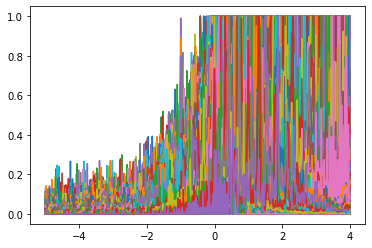

In [10]:
plotter=total_df.drop('make',axis=1)
for i in plotter.index:
    plt.plot(plotter.loc[i,:])

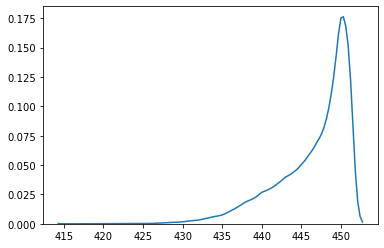

In [11]:
total_df = total_df.loc[(total_df <= total_df.quantile(.99)).sum(axis=1)>440,:]
sns.kdeplot((total_df <= total_df.quantile(.99)).sum(axis=1))

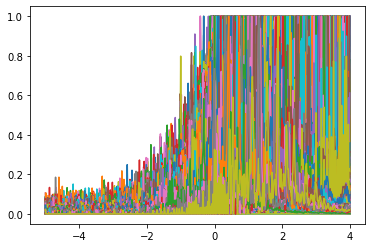

In [13]:
plotter=total_df.drop('make',axis=1)
for i in plotter.index:
    plt.plot(plotter.loc[i,:])

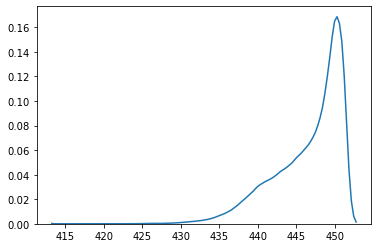

In [15]:
total_df = total_df.loc[(total_df <= total_df.quantile(.99)).sum(axis=1)>440,:]
sns.kdeplot((total_df <= total_df.quantile(.99)).sum(axis=1))

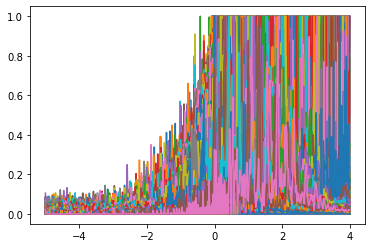

In [16]:
plotter=total_df.drop('make',axis=1)
for i in plotter.index:
    plt.plot(plotter.loc[i,:])

In [109]:
len(total_df)

32757

<ipython-input-179-012a11e485c7>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 11 Text major ticklabel objects>)

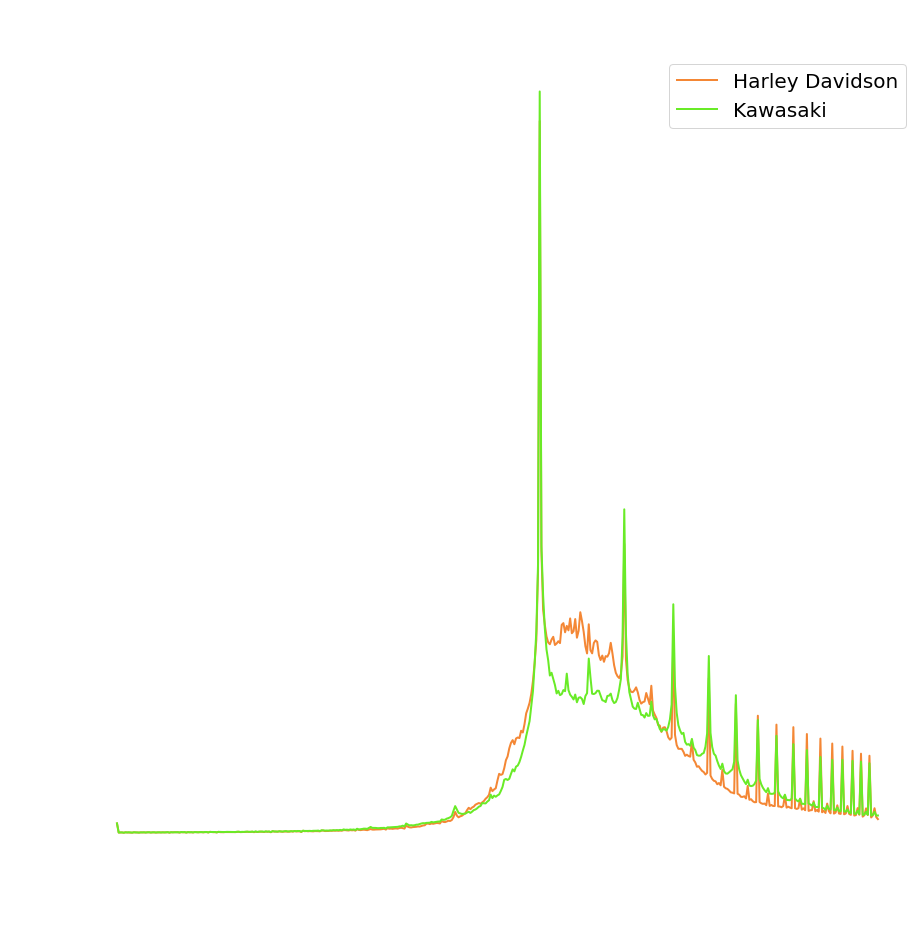

In [179]:
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.plot(total_df.groupby('make').mean().loc['harley+davidson',:], color= '#f48735',linewidth=2,label='Harley Davidson')
plt.plot(total_df.groupby('make').mean().loc['kawasaki',:], color='#69eb27',linewidth=2,label='Kawasaki')
plt.xlabel('Relative Base 2 Log of Frequency',fontsize=30,color='white')
plt.ylabel('Amplitude',fontsize=30,color='white')
plt.title('Normalized Motorcycle FFTs',fontsize=50,color='white')
plt.legend(fontsize=20)
ax=plt.axes()
ax.set_facecolor('#00000000')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors="white")
ax.tick_params(axis='y', colors="white")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [160]:
X=total_df.drop('make',axis=1)
y=total_df.make
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=27)

In [161]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 300,class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300)

In [162]:
from sklearn.ensemble import ExtraTreesClassifier
et_model = RandomForestClassifier(n_estimators = 300,class_weight='balanced')
et_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300)

In [163]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=15,weights='distance',metric='manhattan')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')

In [164]:
import xgboost as xgb
gbm = xgb.XGBClassifier( 
                        n_estimators=1000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.4, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
xgb_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

In [24]:
def get_scores(target,data,model):
    scores={}
    val = pd.DataFrame()
    val['target'] = target
    val['prediction'] = model.predict(data)
    val['correct'] = val['target'] == val['prediction']
    for category in list(target.value_counts().index):
        scores[category]={}
        val['false_'+category] = (val['prediction']==category) & (val['correct'] == False)
        val['true_'+category] = (val['prediction']==category) & val['correct']
        precision = val['true_'+category].sum()/(val['prediction'] == category).sum()
        recall = val['true_'+category].sum()/(val['target'] == category).sum()
        f1 = 2*precision*recall/(recall+precision)
        scores[category]['Precision']=precision
        scores[category]['Recall']=recall
        scores[category]['F1']=f1
    return scores

In [25]:
print('K Nearest Neighbors:')
score_dict = get_scores(y_val,X_val,knn_model)
for category in score_dict.keys():
    print(category)
    for item in score_dict[category].items():
        print(item)
print('')
print('Random Forest:')
score_dict = get_scores(y_val,X_val,rf_model)
for category in score_dict.keys():
    print(category)
    for item in score_dict[category].items():
        print(item)
print('')
print('XGBoost:')
score_dict = get_scores(y_val,X_val,xgb_model)
for category in score_dict.keys():
    print(category)
    for item in score_dict[category].items():
        print(item)
print('')
print('Extra Trees:')
score_dict = get_scores(y_val,X_val,et_model)
for category in score_dict.keys():
    print(category)
    for item in score_dict[category].items():
        print(item)

K Nearest Neighbors:
harley+davidson
('Precision', 0.8287096774193549)
('Recall', 0.866441821247892)
('F1', 0.8471558120362737)
kawasaki
('Precision', 0.8150397010742644)
('Recall', 0.7666959578207382)
('F1', 0.7901290468643876)

Random Forest:
harley+davidson
('Precision', 0.8071178900540197)
('Recall', 0.8566610455311973)
('F1', 0.8311518324607329)
kawasaki
('Precision', 0.7970391595033429)
('Recall', 0.7333040421792618)
('F1', 0.7638443935926774)

XGBoost:
harley+davidson
('Precision', 0.8413429888084266)
('Recall', 0.8620573355817875)
('F1', 0.8515742128935533)
kawasaki
('Precision', 0.8143440762596459)
('Recall', 0.7882249560632689)
('F1', 0.8010716677829871)

Extra Trees:
harley+davidson
('Precision', 0.8112667091024824)
('Recall', 0.8596964586846543)
('F1', 0.8347797609300802)
kawasaki
('Precision', 0.8018103858980467)
('Recall', 0.7394551845342706)
('F1', 0.7693714285714285)


In [165]:
def ROC_curve(data,target,model):
    threshold = np.linspace(0,1,num=500)
    predictions = model.predict_proba(data)[:,0]
    actuals = target == target.values[0]
    ROC={'TPR':[],'FPR':[]}
    for value in threshold:
        prediction = predictions>value
        false_positives = (prediction > actuals).sum()
        true_positives = (prediction & actuals).sum()
        actual_positives = actuals.sum()
        actual_negatives = len(actuals)-actual_positives
        ROC['FPR'].append(false_positives/actual_negatives)
        ROC['TPR'].append(true_positives/actual_positives)
    return pd.DataFrame(ROC)

<ipython-input-176-9667311eea80>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

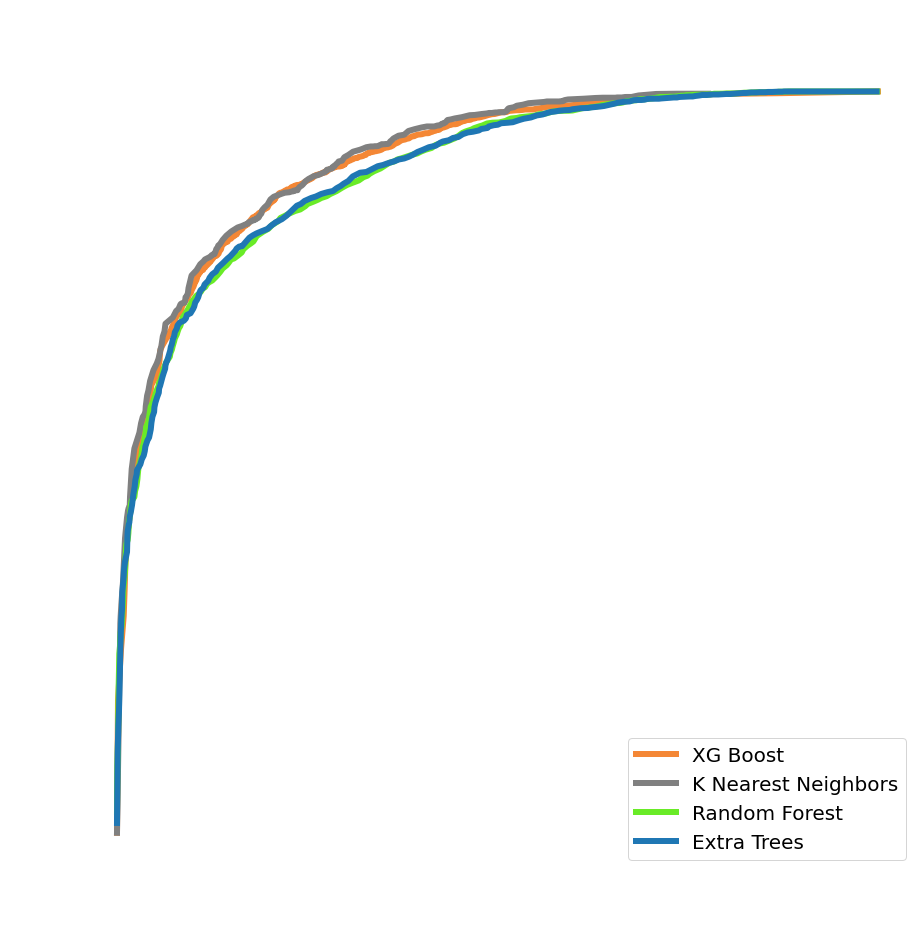

In [176]:
fig = plt.gcf()
fig.set_size_inches(15, 15)
sns.lineplot(x='FPR', y='TPR', data=ROC_curve(X_val,y_val,xgb_model),
             linewidth=6,label='XG Boost',color= '#f48735')
sns.lineplot(x='FPR', y='TPR', data=ROC_curve(X_val,y_val,knn_model),
             linewidth=6,label='K Nearest Neighbors',color='gray')
sns.lineplot(x='FPR', y='TPR', data=ROC_curve(X_val,y_val,rf_model),
             linewidth=6,label='Random Forest',color='#69eb27')
sns.lineplot(x='FPR', y='TPR', data=ROC_curve(X_val,y_val,et_model),
             linewidth=6,label='Extra Trees')
plt.xlabel('False Positive Rate',fontsize=30,color='white')
plt.ylabel('True Positive Rate',fontsize=30,color='white')
plt.title('ROC Plot',fontsize=50,color='white')
plt.legend(fontsize=20)
ax=plt.axes()
ax.set_facecolor('#00000000')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors="white")
ax.tick_params(axis='y', colors="white")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

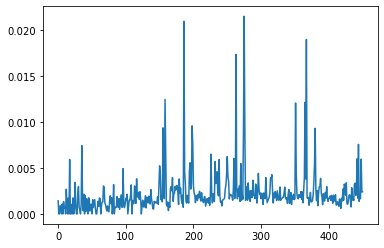

In [40]:
plt.plot(xgb_model.feature_importances_)

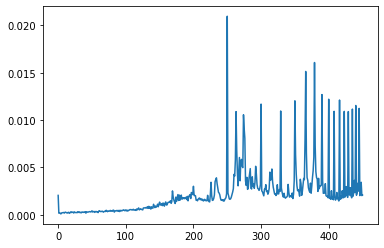

In [38]:
plt.plot(rf_model.feature_importances_)

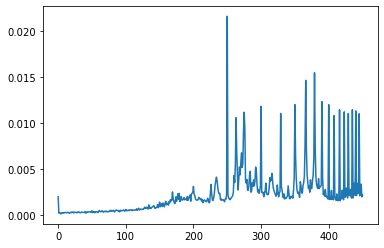

In [39]:
plt.plot(et_model.feature_importances_)

Text(0.5, 1.0, 'Extra Trees')

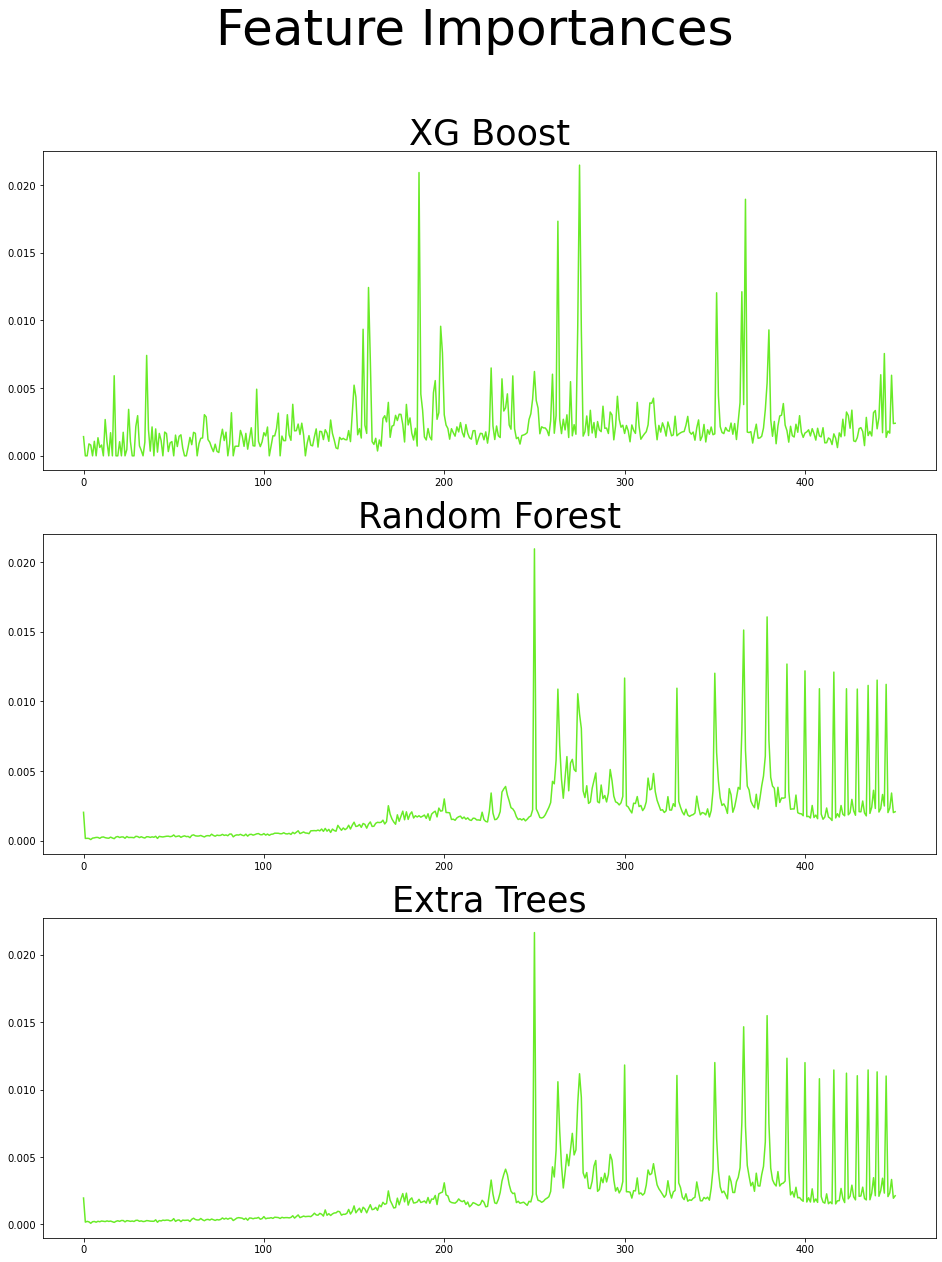

In [108]:
fig, axs = plt.subplots(3)
fig.set_size_inches(16, 20)
fig.suptitle('Feature Importances',fontsize=50)
axs[0].plot(xgb_model.feature_importances_,label='XG Boost',color='#69eb27')
axs[0].set_title('XG Boost',fontsize=35)
axs[1].plot(rf_model.feature_importances_,label='Random Forest',color='#69eb27')
axs[1].set_title('Random Forest',fontsize=35)
axs[2].plot(et_model.feature_importances_,label='Extra Trees',color='#69eb27')
axs[2].set_title('Extra Trees',fontsize=35)

<ipython-input-159-980e401491d5>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12]),
 <a list of 8 Text major ticklabel objects>)

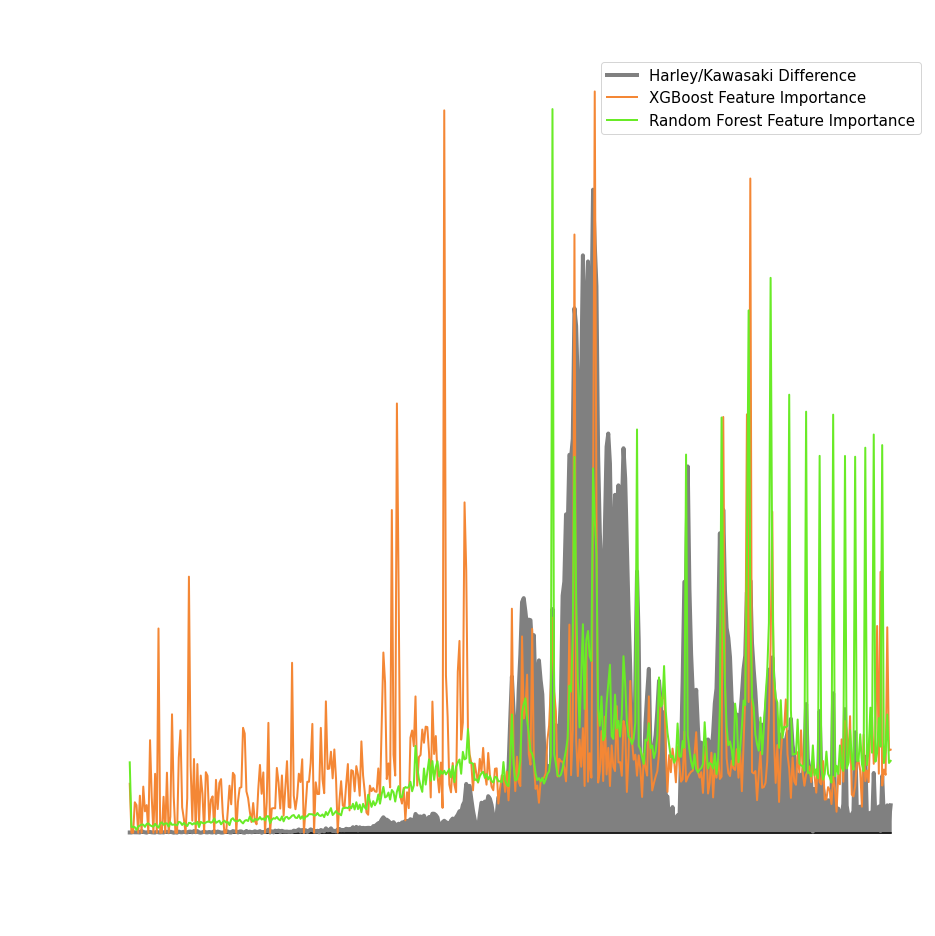

In [159]:
RandomForest=pd.Series(rf_model.feature_importances_)
RandomForest.index=np.linspace(-5,4,num=451)
XGBoost=pd.Series(xgb_model.feature_importances_)
XGBoost.index=np.linspace(-5,4,num=451)
fig = plt.gcf()
fig.set_size_inches(15, 15)
difference=abs(total_df.groupby('make').mean().loc['harley+davidson',:]
               -total_df.groupby('make').mean().loc['kawasaki',:])
x=pd.DataFrame(np.zeros(451),index=np.linspace(-5,4,num=451))
plt.plot(x,color='black')
plt.fill_between(x.index,x[0], difference, color='gray')
plt.plot(difference,linewidth=4,color='gray',label='Harley/Kawasaki Difference')
plt.plot(XGBoost*5,color= '#f48735',linewidth=2,label='XGBoost Feature Importance')
#plt.plot(total_df.groupby('make').mean().loc['harley+davidson',:], color= '#f48735',linewidth=3,label='Harley Davidson')
#plt.plot(total_df.groupby('make').mean().loc['kawasaki',:], color='#69eb27',linewidth=3,label='Kawasaki')

plt.plot(RandomForest*5,linewidth=2,label='Random Forest Feature Importance',color='#69eb27')
plt.xlabel('Relative Base 2 Log of Frequency',fontsize=30,color='white')
plt.ylabel('Amplitude',fontsize=30,color='white')
plt.title('Feature Importance and FFTs',fontsize=50,color='white')
plt.legend(fontsize=15)
ax=plt.axes()
ax.set_facecolor('#00000000')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors="white")
ax.tick_params(axis='y', colors="white")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



In [36]:
rf_model = RandomForestClassifier(n_estimators = 300,class_weight='balanced')
rf_model.fit(X_train_val, y_train_val)


gbm = xgb.XGBClassifier( 
                        n_estimators=1000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.4, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

eval_set=[(X_train_val,y_train_val),(X_test,y_test)]
xgb_model = gbm.fit( 
                    X_train_val, y_train_val, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )


et_model = RandomForestClassifier(n_estimators = 300,class_weight='balanced')
et_model.fit(X_train_val, y_train_val)

RandomForestClassifier(class_weight='balanced', n_estimators=300)

In [37]:
print('Random Forest:')
score_dict = get_scores(y_test,X_test,rf_model)
for category in score_dict.keys():
    print(category)
    for item in score_dict[category].items():
        print(item)
print('')
print('XGBoost:')
score_dict = get_scores(y_test,X_test,xgb_model)
for category in score_dict.keys():
    print(category)
    for item in score_dict[category].items():
        print(item)
print('')
print('Extra Trees:')
score_dict = get_scores(y_test,X_test,et_model)
for category in score_dict.keys():
    print(category)
    for item in score_dict[category].items():
        print(item)

Random Forest:
harley+davidson
('Precision', 0.820872671599898)
('Recall', 0.8636241610738256)
('F1', 0.8417059131344846)
kawasaki
('Precision', 0.8070641853399164)
('Recall', 0.7516802263883976)
('F1', 0.7783882783882784)

XGBoost:
harley+davidson
('Precision', 0.839851024208566)
('Recall', 0.8475167785234899)
('F1', 0.8436664885088188)
kawasaki
('Precision', 0.7966344432509846)
('Recall', 0.7870534135125575)
('F1', 0.7918149466192171)

Extra Trees:
harley+davidson
('Precision', 0.8194835080542061)
('Recall', 0.8604026845637583)
('F1', 0.8394447354635935)
kawasaki
('Precision', 0.8031048845134419)
('Recall', 0.7502652989034312)
('F1', 0.7757863935625458)


In [180]:
rf_model = RandomForestClassifier(n_estimators = 300,class_weight='balanced')
rf_model.fit(X, y)


gbm = xgb.XGBClassifier( 
                        n_estimators=1000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.4, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

#eval_set=[(X_train_val,y_train_val),(X_test,y_test)]
xgb_model = gbm.fit( 
                    X, y, 
                    #eval_set=eval_set,
                    #eval_metric='error', 
                    #early_stopping_rounds=50,
                    verbose=False
                   )


et_model = RandomForestClassifier(n_estimators = 300,class_weight='balanced')
et_model.fit(X, y)

RandomForestClassifier(class_weight='balanced', n_estimators=300)

In [262]:
with open('test_motorcycles.pickle', 'rb') as to_read:
    final_test_df = pickle.load(to_read)
to_read.close()

In [263]:
final_test_df.dropna(inplace=True)
len(final_test_df)

2606

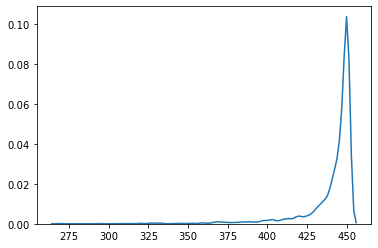

In [264]:
sns.kdeplot((final_test_df <= total_df.quantile(.99)).sum(axis=1))

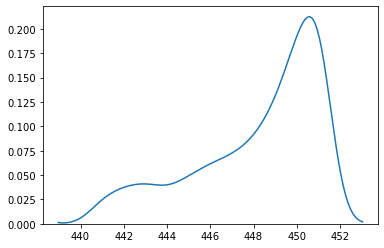

In [265]:
final_test_df.dropna(inplace=True)

final_test_df = final_test_df.loc[(final_test_df <= total_df.quantile(.99)).sum(axis=1)>440,:]
sns.kdeplot((final_test_df <= total_df.quantile(.99)).sum(axis=1))

In [266]:
len(final_test_df)

1928

In [267]:

final_x=final_test_df.drop(['make','file'],axis=1)
final_test_df['rf']=rf_model.predict(final_x)
final_test_df['xgb']=xgb_model.predict(final_x)
final_test_df['et']=et_model.predict(final_x)

In [268]:
final_test_df

,-5.0,-4.98,-4.96,-4.94,-4.92,-4.9,-4.88,-4.86,-4.84,-4.82,...,3.92,3.9399999999999995,3.960000000000001,3.9800000000000004,4.0,file,make,rf,xgb,et
0,0.008901,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.020719,0.021844,0.019517,0.025710,0.027272,10.mp3,kawasaki,kawasaki,kawasaki,kawasaki
1,0.003066,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.002184,0.0,...,0.019360,0.013707,0.014085,0.013340,0.022759,10.mp3,kawasaki,kawasaki,harley+davidson,kawasaki
2,0.001599,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.009232,0.0,...,0.018363,0.035277,0.031579,0.026758,0.034025,10.mp3,kawasaki,kawasaki,kawasaki,kawasaki
12,0.008893,0.0,0.0,0.000000,0.0,0.000000,0.003096,0.0,0.000000,0.0,...,0.079285,0.069145,0.091846,0.090537,0.080768,10.mp3,kawasaki,harley+davidson,harley+davidson,harley+davidson
13,0.010008,0.0,0.0,0.000000,0.0,0.010177,0.000000,0.0,0.000000,0.0,...,0.049101,0.052660,0.050385,0.061997,0.043923,10.mp3,kawasaki,harley+davidson,harley+davidson,harley+davidson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606,0.007990,0.0,0.0,0.010318,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.005221,0.005898,0.003035,0.002763,0.003587,7.mp3,harley+davidson,harley+davidson,harley+davidson,harley+davidson
2608,0.012102,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.007722,0.010789,0.007343,0.005126,0.005503,7.mp3,harley+davidson,harley+davidson,kawasaki,harley+davidson
2609,0.023232,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.008057,0.003891,0.003292,0.003237,0.002911,7.mp3,harley+davidson,harley+davidson,harley+davidson,harley+davidson
2610,0.043639,0.0,0.0,0.000000,0.0,0.020105,0.000000,0.0,0.000000,0.0,...,0.006876,0.010523,0.010411,0.006306,0.008369,7.mp3,harley+davidson,harley+davidson,harley+davidson,harley+davidson


In [269]:
final_test_df['rf_correct']=final_test_df['make']==final_test_df['rf']
final_test_df['xgb_correct']=final_test_df['make']==final_test_df['xgb']
final_test_df['et_correct']=final_test_df['make']==final_test_df['et']

In [270]:
final_test_df.sum()

-5.0                                                     21.6903
-4.98                                                   0.588005
-4.96                                                   0.968064
-4.94                                                   0.787492
-4.92                                                   0.366346
                                     ...                        
xgb            kawasakiharley+davidsonkawasakiharley+davidson...
et             kawasakikawasakikawasakiharley+davidsonharley+...
rf_correct                                                  1766
xgb_correct                                                 1772
et_correct                                                  1762
Length: 459, dtype: object

In [272]:
final_test_df.groupby(['make','file']).mean()

-5.0     -4.98     -4.96     -4.94     -4.92  \
make            file                                                       
harley+davidson 0.mp3   0.016212  0.000000  0.000000  0.000000  0.000000   
                1.mp3   0.012432  0.000000  0.000287  0.000000  0.000000   
                10.mp3  0.013075  0.000000  0.000132  0.000000  0.000000   
                11.mp4  0.017626  0.000000  0.000000  0.000000  0.000000   
                12.mp3  0.010403  0.000214  0.000905  0.000000  0.000000   
                13.mp4  0.009180  0.000787  0.001078  0.000185  0.000470   
                14.mp3  0.012513  0.000186  0.002024  0.001130  0.000000   
                3.mp3   0.010049  0.000331  0.000201  0.000267  0.000000   
                4.mp3   0.010138  0.000000  0.000645  0.001536  0.000622   
                5.mp3   0.008845  0.000000  0.000000  0.000158  0.000000   
                6.mp3   0.010537  0.000000  0.000000  0.000000  0.000039   
                7.mp3   0.016902  0.000000  0.001054  0.000794  0.000000   
                9.mp4   0.009799  0.000000  0.000173  0.000058  0.000000   
kawasaki        0.mp3   0.008311  0.001062  0.000612  0.000765  0.000994   
                1.mp4   0.020857  0.000177  0.000815  0.000578  0.000000   
                10.mp3  0.006603  0.000000  0.000000  0.000000  0.000000   
                11.mp3  0.007985  0.000184  0.000034  0.000206  0.000191   
                12.mp3  0.004848  0.000700  0.000593  0.000224  0.000843   
                14.mp3  0.000000  0.000000  0.000000  0.000000  0.000000   
                3.mp3   0.009909  0.000979  0.000416  0.000270  0.000000   
                4.mp3   0.009802  0.000213  0.000579  0.000661  0.000087   
                5.mp4   0.010824  0.000933  0.000000  0.000709  0.000327   
                6.mp3   0.008217  0.000468  0.000509  0.000249  0.000000   
                7.mp3   0.014204  0.000136  0.001025  0.000000  0.000000   
                8.mp4   0.009845  0.000607  0.000984  0.000000  0.000000   
                9.mp3   0.002524  0.000292  0.000382  0.000333  0.000324   

                            -4.9     -4.88     -4.86     -4.84     -4.82  ...  \
make            file                                                      ...   
harley+davidson 0.mp3   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
                1.mp3   0.000000  0.000213  0.000216  0.000000  0.000330  ...   
                10.mp3  0.000000  0.000000  0.000102  0.000000  0.000000  ...   
                11.mp4  0.001505  0.002696  0.000000  0.000000  0.000000  ...   
                12.mp3  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
                13.mp4  0.000028  0.000000  0.000000  0.000118  0.000291  ...   
                14.mp3  0.003683  0.001652  0.000000  0.000564  0.000000  ...   
                3.mp3   0.000292  0.000673  0.001008  0.001238  0.000000  ...   
                4.mp3   0.003156  0.000856  0.000729  0.001255  0.000459  ...   
                5.mp3   0.000000  0.000000  0.000000  0.000377  0.000000  ...   
                6.mp3   0.000085  0.000404  0.000328  0.000179  0.000498  ...   
                7.mp3   0.001547  0.000000  0.000248  0.000000  0.000000  ...   
                9.mp4   0.000084  0.000000  0.000296  0.000096  0.000000  ...   
kawasaki        0.mp3   0.001472  0.001122  0.000782  0.000669  0.000851  ...   
                1.mp4   0.000477  0.000380  0.000916  0.001500  0.000000  ...   
                10.mp3  0.001696  0.000221  0.000000  0.000815  0.000191  ...   
                11.mp3  0.000000  0.000344  0.000806  0.000400  0.000381  ...   
                12.mp3  0.000869  0.000903  0.000393  0.000765  0.000680  ...   
                14.mp3  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
                3.mp3   0.000000  0.000800  0.001412  0.000467  0.000000  ...   
                4.mp3   0.000368  0.000603  0.000461  0.000436  0.000341  ...   
                5.mp4   0.000000  0.

In [293]:
final_test_df.rolling(window=20).mean().quantile(0.02)

-5.0                  0.003988
-4.98                 0.000000
-4.96                 0.000000
-4.94                 0.000000
-4.92                 0.000000
                        ...   
3.9800000000000004    0.003245
4.0                   0.003392
rf_correct            0.400000
xgb_correct           0.500000
et_correct            0.350000
Name: 0.02, Length: 454, dtype: float64

In [278]:
final_test_df.groupby(['make']).mean()

,-5.0,-4.98,-4.96,-4.94,-4.92,-4.9,-4.88,-4.86,-4.84,-4.82,...,3.880000000000001,3.9000000000000004,3.92,3.9399999999999995,3.960000000000001,3.9800000000000004,4.0,rf_correct,xgb_correct,et_correct
make,,,,,,,,,,,,,,,,,,,,,
harley+davidson,0.010517,0.000135,0.000392,0.000356,0.000111,0.000707,0.000401,0.000446,0.000530,0.000136,...,0.013818,0.016216,0.013802,0.013975,0.013635,0.014377,0.016940,0.924276,0.928731,0.922049
kawasaki,0.011889,0.000453,0.000598,0.000454,0.000259,0.000510,0.000500,0.000579,0.000778,0.000236,...,0.013844,0.031314,0.014251,0.013483,0.013722,0.012990,0.012471,0.908738,0.910680,0.906796


In [279]:
final_test_df.mean()

-5.0                  0.011250
-4.98                 0.000305
-4.96                 0.000502
-4.94                 0.000408
-4.92                 0.000190
                        ...   
3.9800000000000004    0.013636
4.0                   0.014553
rf_correct            0.915975
xgb_correct           0.919087
et_correct            0.913900
Length: 454, dtype: float64